In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from spring_rods_system_setup import SpringRodsSystemSetup
from spring_rods_system_solver import SpringRodsSystemSolver

from utils.computational_utils import l2_norm
from utils.plot_utils import plot_displacements_and_stress

In [2]:
plt.rcParams.update({
    'axes.grid': True,
    'figure.facecolor': 'white',
    'mathtext.default': 'regular'
})

In [3]:
experiment_setups = [
    {
        'body_forces': lambda x: np.where(x < 0, 1, -1),
        'interval': (-1, 1),
        'spring_len': 1
    },
    {
        'body_forces': lambda x: np.where(x < 0, -1, 1),
        'interval': (-1, 1),
        'spring_len': 1
    },
    {
        'body_forces': lambda x: np.where(x < 0, 1, 0),
        'interval': (-1, 1),
        'spring_len': 1
    },
    {
        'body_forces': lambda x: np.where(x < 0, -1, 0),
        'interval': (-1, 1),
        'spring_len': 1
    },
    {
        'body_forces': lambda x: np.where(x < 0, 1, 1),
        'interval': (-1, 1),
        'spring_len': 1
    },
    {
        'body_forces': lambda x: np.where(x < 0, 1, -1),
        'interval': (-1, 1),
        'spring_len': 0.3
    }
]

In [4]:
experiment_number = 1

In [5]:
model = SpringRodsSystemSetup(
    step_size=1/256,
    material_const=(1, 1),
    spring_const=(1, 1),
    **experiment_setups[experiment_number - 1]
)
solver = SpringRodsSystemSolver(model)

In [6]:
spring_const_discrete = [0.01, 0.5, 1, 1.5, 2]

In [7]:
displacement_results = []
stress_results = []

left_end_results = []
right_end_results = []

for const in tqdm(spring_const_discrete):
    model.set_spring_const((const, const))
    displacements = solver()

    stresses = solver.compute_stresses(displacements)
    displacement_results.append(displacements)
    stress_results.append(stresses)

    left_end_results.append(displacements[0][-1])
    right_end_results.append(displacements[1][0])

100%|██████████| 5/5 [00:23<00:00,  4.64s/it]


In [8]:
compression = []
for displ in displacement_results:
    left_end_displ = displ[0][-1]
    right_end_displ = displ[1][0]
    compression.append(left_end_displ - right_end_displ)
compression = np.array(compression)

stiff_coef_idx = -1
stiff_coef = 'k'
if np.allclose(compression, 0, atol=1e-6):
    stiff_coef_idx = 1
    stiff_coef = '$k_2$'
elif all(compression > 0):
    stiff_coef_idx = 0
    stiff_coef = '$k_1$'
elif all(compression < 0):
    stiff_coef_idx = 1
    stiff_coef = '$k_2$'
else:
    print(compression)
    raise Exception('lack of consistency')

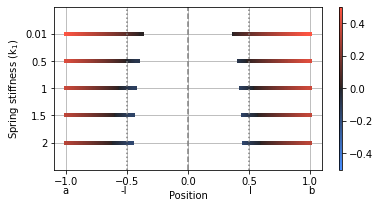

In [9]:
# TODO important for experiment 6
limits = (-1, 1) if experiment_number == 6 else (-0.5, 0.5)

assert np.min(stress_results) > limits[0] and np.max(stress_results) < limits[1]

plt.gcf().set_size_inches(6, 3)

plot_displacements_and_stress(
    model,
    zip(displacement_results, stress_results),
    spring_const_discrete,
    parameter_name=f'Spring stiffness ({stiff_coef})',
    limits=limits,
    path=f'./plots/spring_stiff_dependence/exp{experiment_number}_full.png'
)

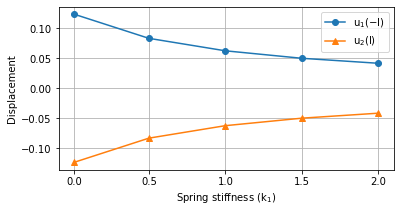

In [10]:
fig = plt.gcf()
fig.set_size_inches((6, 3))

# TODO this is important for experiment 5
if experiment_number == 5:
    plt.ylim(-0.5, 0.5)

plt.plot(spring_const_discrete, left_end_results, label='$u_1(-l)$', marker='o')
plt.plot(spring_const_discrete, right_end_results, label='$u_2(l)$', marker='^')

plt.xticks(spring_const_discrete, (f'{x:.1f}' for x in spring_const_discrete))

plt.xlabel(f'Spring stiffness ({stiff_coef})')
plt.ylabel('Displacement')
plt.legend()

plt.savefig(f'plots/spring_stiff_dependence/exp{experiment_number}_ends_of_rods_displacement.png', bbox_inches='tight')

In [11]:
def neg_p_func(k_param: float, displacement: tuple):
    return k_param * (-displacement[0][-1] + displacement[1][0])

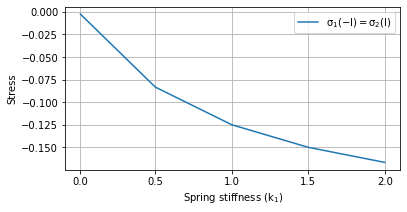

In [15]:
fig = plt.gcf()
fig.set_size_inches((6, 3))

# TODO this is important for experiment 5
if experiment_number == 5:
    plt.ylim(-0.2, 0.2)

p_func_values = [neg_p_func(k, d) for k, d in zip(spring_const_discrete, displacement_results)]

# TODO this is important for experiment 6
if experiment_number == 6:
    plt.plot(spring_const_discrete, p_func_values, label='$-p(\\theta(u))$')
    plt.plot(spring_const_discrete, [left[-1] for left, _ in stress_results], label='$\sigma_1(-l)$')
    plt.plot(spring_const_discrete, [right[0] for _, right in stress_results], label='$\sigma_2(l)$')
else:
    plt.plot(spring_const_discrete, p_func_values, label='$\sigma_1(-l) = \sigma_2(l)$')

plt.xticks(spring_const_discrete, (f'{x:.1f}' for x in spring_const_discrete))

plt.xlabel(f'Spring stiffness ({stiff_coef})')
plt.ylabel('Stress')
plt.legend()

plt.savefig(f'plots/spring_stiff_dependence/exp{experiment_number}_stress_on_ends_of_rods.png', bbox_inches='tight')

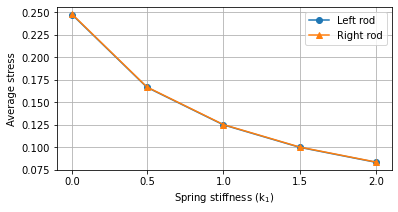

In [17]:
fig = plt.gcf()
fig.set_size_inches((6, 3))

plt.xticks(spring_const_discrete, (f'{x:.1f}' for x in spring_const_discrete))

avg_stress_left = [np.average(s[0]) for s in stress_results]
avg_stress_right = [np.average(s[1]) for s in stress_results]
plt.plot(spring_const_discrete, avg_stress_left, label='Left rod', marker='o')
plt.plot(spring_const_discrete, avg_stress_right, label='Right rod', marker='^')
plt.ylabel('Average stress')
plt.xlabel(f'Spring stiffness ({stiff_coef})')
plt.legend()
plt.savefig(f'plots/spring_stiff_dependence/exp{experiment_number}_avg_stress.png', bbox_inches='tight')

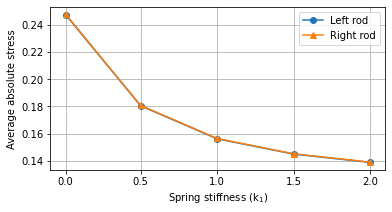

In [18]:
fig = plt.gcf()
fig.set_size_inches((6, 3))

# TODO this is important for experiment 5
if experiment_number == 5:
    plt.ylim(-0.5, 0.5)

plt.xticks(spring_const_discrete, (f'{x:.1f}' for x in spring_const_discrete))

avg_stress_left = [np.average(np.abs(s[0])) for s in stress_results]
avg_stress_right = [np.average(np.abs(s[1])) for s in stress_results]
plt.plot(spring_const_discrete, avg_stress_left, label='Left rod', marker='o')
plt.plot(spring_const_discrete, avg_stress_right, label='Right rod', marker='^')
plt.ylabel('Average absolute stress')
plt.xlabel(f'Spring stiffness ({stiff_coef})')
plt.legend()
plt.savefig(f'plots/spring_stiff_dependence/exp{experiment_number}_avg_abs_stress.png', bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


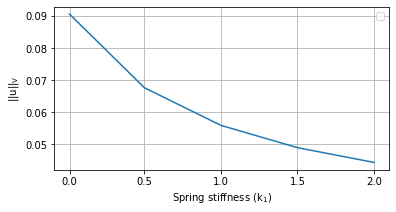

In [19]:
fig = plt.gcf()
fig.set_size_inches((6, 3))

# TODO this is important for experiment 5
if experiment_number == 5:
    plt.ylim(-0.5, 0.5)

plt.xticks(spring_const_discrete, (f'{x:.1f}' for x in spring_const_discrete))

norm_of_solution = [l2_norm(d, model.domain) for d in displacement_results]

plt.plot(spring_const_discrete, norm_of_solution)
plt.ylabel('$\|\|u\|\|_{V}$')
plt.xlabel(f'Spring stiffness ({stiff_coef})')
plt.legend()
plt.savefig(f'plots/spring_stiff_dependence/exp{experiment_number}_L2_norm.png', bbox_inches='tight')